# Introduction

This is an exploration of autoencoders for representing gene expression data. The main question here is to to explore whether beta autoencoders better capture the variance in the data than vanilla autoencoders. This analysis will test the findings of Chow et al. on a different dataset.  

## Setting up the environment
* Specifically, I am setting up the analysis to be run in a GPU environment, if a GPU is present. 


In [22]:
import sys
import pathlib
import numpy as np
import pandas as pd
import scipy as sp
sys.path.insert(0, "../scripts")
from utils import load_data  
from vae import VAE

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tensorflow import keras

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf

output_dir = pathlib.Path("../data")
output_dir.mkdir(exist_ok=True)

import pyreadr
import pickle

from sklearn.decomposition import PCA

## Loading in the data
Beginning with the data from GSEA-InContext


In [3]:
# load the data
# recount3 sample
full_data = pyreadr.read_r('../../recount_sample.Rda')


In [4]:
full_data = full_data["recount_expression"]

In [5]:
#print("sample shape", sample_annotations.shape)
print("full data shape", full_data.shape)
# columns are samples, rows are genes



full data shape (66484, 14534)


In [17]:
nonzero = full_data.astype(bool).sum(axis=1)
#print full_data.astype(bool).sum(axis=1)

In [18]:
nonzero.describe()


count    66484.000000
mean       311.551291
std        665.213805
min          0.000000
25%         26.000000
50%         64.000000
75%        167.000000
max      10864.000000
dtype: float64

In [94]:
todrop = nonzero < 167
todrop = full_data.index.values[np.where(todrop)[0]]

In [135]:
test = full_data.drop(todrop)

In [136]:
test.shape

(16636, 14534)

In [137]:
test += 1e-6
test = np.log2(test)

In [139]:
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler = scaler.fit(test)

In [140]:
test = scaler.transform(test)

test = pd.DataFrame(test)
type(test)

pandas.core.frame.DataFrame

In [141]:
pca=PCA(n_components = 2)
pca.fit(test)
pca_full = pca.transform(test)

                 

In [142]:
pca_full = pd.DataFrame(pca_full)

In [99]:
# z_0 = sp.stats.zscore(pca_full[0])
# z_1 = sp.stats.zscore(pca_full[1])

In [100]:
# z_0_outliers = z_0 > 3
# z_1_outliers = z_1 > 3

In [101]:
# print(np.where(z_0_outliers)[0])
# np.where(z_1_outliers)[0]


[34758 34775 34783 35212 35216 35298 35299 35309 35310 35315 35413 35626
 36235 36238 36384]


array([29286, 29556])

In [84]:
# toremove = [17178, 34758, 34775, 34783, 34787 ,35212 ,35216 ,35298 ,35299 ,35309 ,35310, 35315,
#  35413, 35427, 35626, 35628, 36235, 36238, 36384 ,36385,29286, 29556 ]
# toremove = full_data.index.values[toremove]
# toremove

array(['SRR2963837', 'SRR3191737', 'SRR3191748', 'SRR3191752',
       'SRR3191755', 'SRR3192067', 'SRR3192204', 'SRR3192037',
       'SRR3192038', 'SRR3192053', 'SRR3192054', 'SRR3192068',
       'SRR3192205', 'SRR3192228', 'SRR3192435', 'SRR3192436',
       'SRR3192149', 'SRR3192150', 'SRR3192294', 'SRR3192295',
       'ERR2568931', 'ERR2569315'], dtype=object)

In [102]:
# full_data = full_data.drop(labels = toremove)

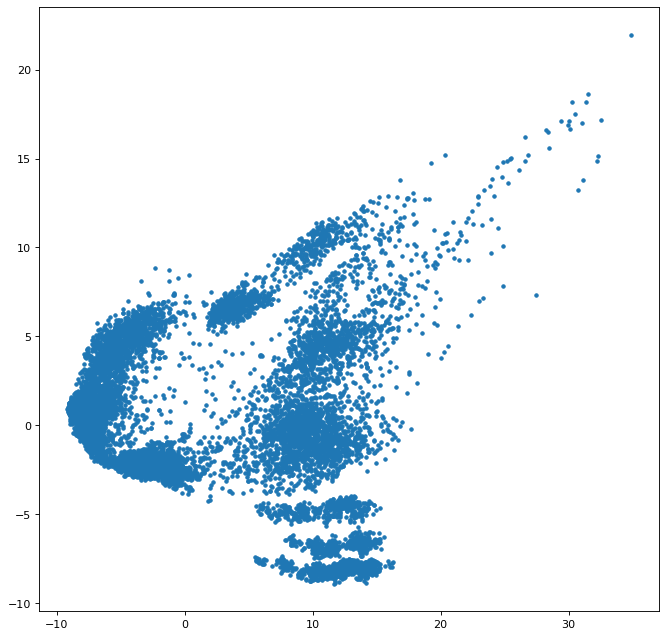

In [143]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_full[0],pca_full[1], marker = ".")
#plt.scatter(pca_reconstruction[0],pca_reconstruction[1], marker = ".", alpha = 0.05)
#plt.xlim([0,.15])
#plt.ylim([0,.15])

In [6]:
# scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
# scaler.fit(full_data)
# minmax_full_data = scaler.transform(full_data)
# minmax_full_data.shape

(66484, 14534)

In [13]:
# minmax_full_data = pd.DataFrame(minmax_full_data)

## Splitting the data
Splitting the data into train, test, and validation datasets (80%,10%,10%). 

* Do I need to consider the experiment assignments in splitting the data?
* I think so, currently stratifying by sample_group variable. This should ensure that the train and test groups have similar amounts of experiment and control data. 
* Actually, on second thought,this may be prohibitive. It reduces the amount of training data to datasets with annotations, while previous experiments have shown that differential expression can be reproduced by simply sampling from the entire data. This is the point of being able to find the specifically expressed genes without metadata.


In [128]:
test_split = .3
seed = 42

# Split data
train_df, test_df = train_test_split(
    test,
    test_size=test_split,
    random_state=seed,
#    stratify = sample_annotations.cell_type,
)

test_df, valid_df = train_test_split(
    test_df,
    test_size=0.5,
    random_state=seed
)


In [129]:
print(train_df.shape)
print(test_df.shape)
print(valid_df.shape)

(11645, 14534)
(2495, 14534)
(2496, 14534)


In [18]:
#sum(train_df[train_df.columns[1]])

2.1556682959713225

## Normalization 
* Normalizing each dataset separately to avoid data leakage from one dataset to another.
* [0,1]

In [4]:
#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
# minmax_train = pd.DataFrame(min_max_scaler.fit_transform(train_df), 
#                             columns = train_df.columns.values,
#                             index = train_df.index.values)
# minmax_test = pd.DataFrame(min_max_scaler.fit_transform(test_df), 
#                             columns = test_df.columns.values,
#                             index = test_df.index.values)

# minmax_valid = pd.DataFrame(min_max_scaler.fit_transform(valid_df), 
#                             columns = valid_df.columns.values,
#                             index = valid_df.index.values)
# # minmax_valid = pd.DataFrame(min_max_scaler.fit_transform(full_data_t), 
# #                             columns = full_data_t.columns.values,
# #                             index = full_data_t.index.values)




In [131]:
# # Output data splits
# train_file = pathlib.Path(output_dir, "recount3_sample_train.tsv.gz")
# test_file = pathlib.Path(output_dir, "recount3_sample_test.tsv.gz")
# valid_file = pathlib.Path(output_dir, "recount3_sample_valid.tsv.gz")
# complete_file = pathlib.Path(output_dir, "recount3_sample_complete.tsv.gz")

# train_df.to_csv(train_file, sep="\t", index=False, float_format="%.5g")
# test_df.to_csv(test_file, sep="\t", index=False, float_format="%.5g")
# valid_df.to_csv(valid_file, sep="\t", index=False, float_format="%.5g")
test.to_csv(complete_file, sep="\t", index=False, float_format="%.5g")

In [144]:
scaler_filename = "./full_data_scaler.pkl"
pickle.dump(scaler, open(scaler_filename, "wb"))